In [1]:
!pip install -q kaggle
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
 cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [ ]:
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# !unzip -o "chest-xray-pneumonia.zip"

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [4]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import cv2
import seaborn as sns

TRAIN_PATH = '/content/drive/MyDrive/kaggle/chest_xray/train/'
TEST_PATH = '/content/drive/MyDrive/kaggle/chest_xray/test/'
VAL_PATH = '/content/drive/MyDrive/kaggle/chest_xray/val/'

### Followed tutorial: https://www.kaggle.com/code/abdmental01/chest-x-ray-xception-94

In [5]:
# Directory containing the "Train" folder
directory = TRAIN_PATH

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

#Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_train = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [6]:
df_train

,filepath,label
0,/content/drive/MyDrive/kaggle/chest_xray/train...,NORMAL
1,/content/drive/MyDrive/kaggle/chest_xray/train...,NORMAL
2,/content/drive/MyDrive/kaggle/chest_xray/train...,NORMAL
3,/content/drive/MyDrive/kaggle/chest_xray/train...,NORMAL
4,/content/drive/MyDrive/kaggle/chest_xray/train...,NORMAL
...,...,...
5211,/content/drive/MyDrive/kaggle/chest_xray/train...,PNEUMONIA
5212,/content/drive/MyDrive/kaggle/chest_xray/train...,PNEUMONIA
5213,/content/drive/MyDrive/kaggle/chest_xray/train...,PNEUMONIA
5214,/content/drive/MyDrive/kaggle/chest_xray/train...,PNEUMONIA


In [7]:
# Directory containing the "Test" folder
directory = TEST_PATH

filepath =[]
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory , fold)

    imgs = os.listdir(f_path)

    for img in imgs:

        img_path = os.path.join(f_path , img)
        filepath.append(img_path)
        label.append(fold)

# Concat data paths with labels
file_path_series = pd.Series(filepath , name= 'filepath')
Label_path_series = pd.Series(label , name = 'label')
df_test = pd.concat([file_path_series ,Label_path_series ] , axis = 1)

In [8]:
df_test

,filepath,label
0,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
1,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
2,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
3,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
4,/content/drive/MyDrive/kaggle/chest_xray/test/...,NORMAL
...,...,...
619,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA
620,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA
621,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA
622,/content/drive/MyDrive/kaggle/chest_xray/test/...,PNEUMONIA


In [9]:
# Shape
print(f"The shape of The Train data is: {df_train.shape}")
print(f"The shape of The Test data is: {df_test.shape}")

The shape of The Train data is: (5216, 2)
The shape of The Test data is: (624, 2)


In [10]:
train_dir = TRAIN_PATH
test_dir = TEST_PATH

IMAGE_SIZE = (256,256)

print('Training Images:')
# Creating the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Testing  Data
print('Validation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('Testing Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

Training Images:
Found 5216 files belonging to 2 classes.
Using 4695 files for training.
Validation Images:
Found 5216 files belonging to 2 classes.
Using 521 files for validation.
Testing Images:
Found 624 files belonging to 2 classes.


In [13]:
from sklearn.preprocessing import LabelEncoder

train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

# Encode Labels

# Define your class labels
class_labels = ['NORMAL', 'PNEUMONIA']

# Instantiate LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder on the class labels
label_encoder.fit(class_labels)

# Transform the labels for training dataset
train_labels_encoded = label_encoder.transform(train_labels)

# Transform the labels for validation dataset
validation_labels_encoded = label_encoder.transform(validation_labels)

# Transform the labels for test dataset
test_labels_encoded = label_encoder.transform(test_labels)

In [14]:
# Shape of the dataset
for image_batch, labels_batch in train_ds:
    print("Shape of X_train: ", image_batch.shape)
    print("Shape of y_train: ", labels_batch.shape)
    break

Shape of X_train:  (32, 256, 256, 3)
Shape of y_train:  (32,)


In [15]:
# Normalizing Pixel Values

# Train Data
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
# Val Data
validation_ds = validation_ds.map(lambda x, y: (x / 255.0, y))
# Test Data
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

<ipython-input-16-f8231ac95a46>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


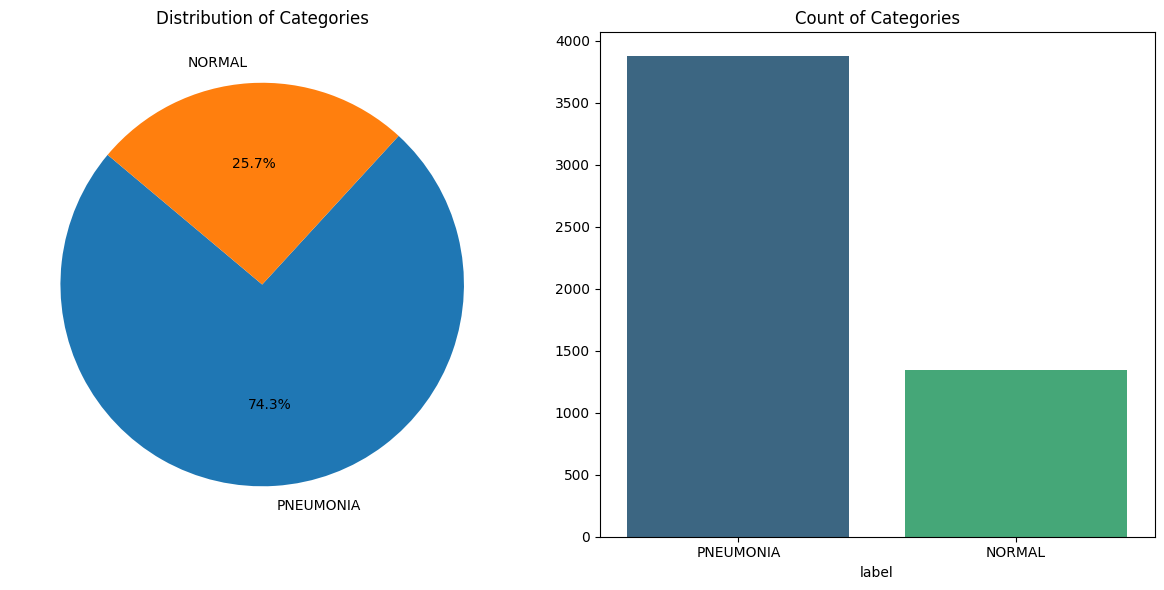

In [16]:
# Count the occurrences of each category in the 'category' column
count = df_train['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

<ipython-input-17-f24f01d2475e>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")


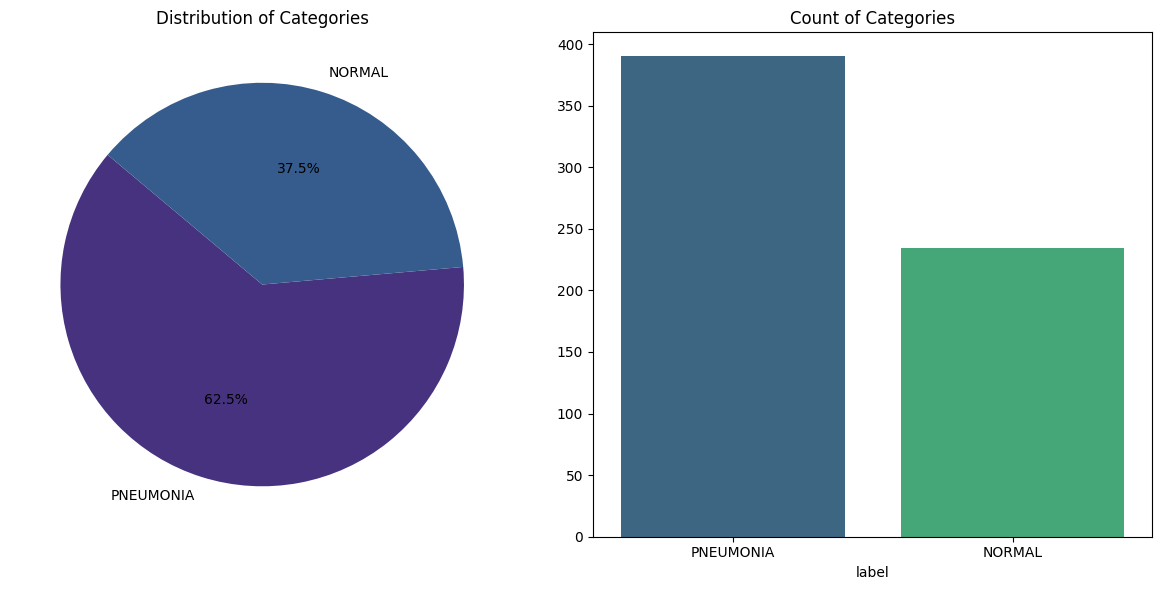

In [17]:
# Count the occurrences of each category in the 'category' column
count = df_test['label'].value_counts()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [24]:
import matplotlib.image as mpimg
def visualize_images(path, num_images=5):
    # Get a list of image filenames in the specified path
    image_filenames = os.listdir(path)

    # Limit the number of images to visualize if there are more than num_images
    num_images = min(num_images, len(image_filenames))

    # Create a figure and axis object to display images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3),facecolor='white')

    # Iterate over the selected images and display them
    for i, image_filename in enumerate(image_filenames[:num_images]):
        # Load the image using Matplotlib
        image_path = os.path.join(path, image_filename)
        image = mpimg.imread(image_path)

        # Display the image
        axes[i].imshow(image)
        axes[i].axis('off')  # Turn off axis
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

/content/drive/MyDrive/kaggle/chest_xray/train/NORMAL


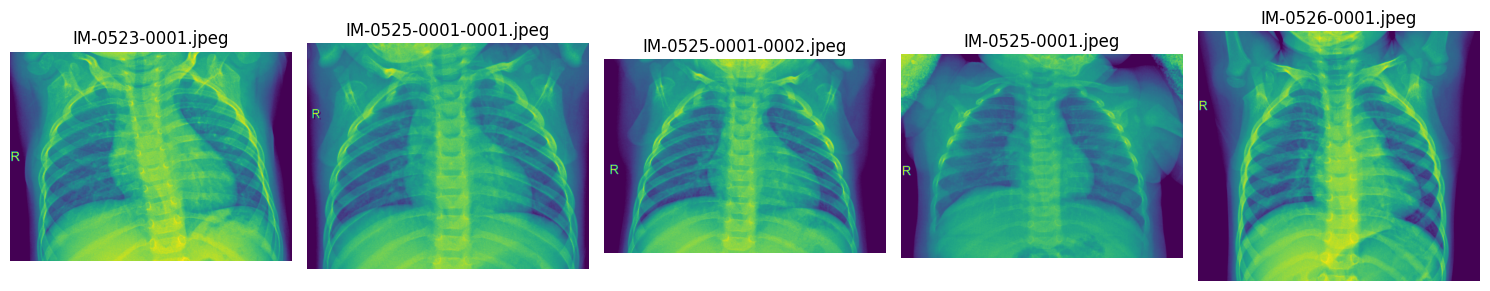

In [26]:
# Specify the path containing the images to visualize
path_to_visualize = TRAIN_PATH + ('NORMAL')
print(path_to_visualize)
# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

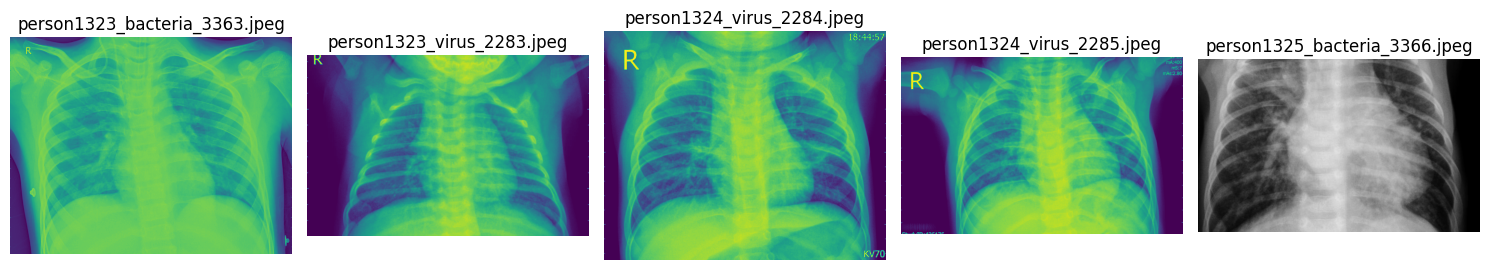

In [27]:
# Specify the path containing the images to visualize
path_to_visualize = TRAIN_PATH + ('PNEUMONIA')

# Visualize some images from the specified path
visualize_images(path_to_visualize, num_images=5)

In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, BatchNormalization, Activation, Dropout, Flatten


model = Sequential([
  Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=[256, 256, 3]),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(filters=128, kernel_size=(3, 3), padding='same'),
    BatchNormalization(),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(units=300),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),

    Dense(units=1),
    BatchNormalization(),
    Activation("sigmoid")
])

model.build()

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)     

In [37]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=["accuracy"])

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history=model.fit(train_ds,
                  epochs=20,
                  validation_data=validation_ds,
                  callbacks = early_stopping)

Epoch 1/20
147/147 [==============================] - 1391s 9s/step - loss: 0.3946 - accuracy: 0.9380 - val_loss: 0.5314 - val_accuracy: 0.7639
Epoch 2/20
147/147 [==============================] - 1381s 9s/step - loss: 0.3315 - accuracy: 0.9725 - val_loss: 0.4818 - val_accuracy: 0.7639
Epoch 3/20
147/147 [==============================] - 1398s 9s/step - loss: 0.2861 - accuracy: 0.9768 - val_loss: 0.3335 - val_accuracy: 0.9424
Epoch 4/20
147/147 [==============================] - 1315s 9s/step - loss: 0.2514 - accuracy: 0.9804 - val_loss: 0.3501 - val_accuracy: 0.9290
Epoch 5/20
147/147 [==============================] - 1316s 9s/step - loss: 0.2235 - accuracy: 0.9823 - val_loss: 0.2251 - val_accuracy: 0.9904
Epoch 6/20
 12/147 [=>............................] - ETA: 22:04 - loss: 0.2146 - accuracy: 0.9818